In [1]:
import zipfile, os
import pandas as pd
import json
import numpy as np

zip_path = "/content/ipl_jsons.zip"
extract_path = "/content/Input_Matches_DATA"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall("/content")

print(f"Number of files extracted: {len(os.listdir(extract_path))}")

Number of files extracted: 1150


In [34]:
# save all necessary files
import joblib
import os

save_dir = "/content/model_and_data"
os.makedirs(save_dir, exist_ok=True)

model_path = os.path.join(save_dir, "rf_model.pkl")
joblib.dump(rf_model, model_path)
print(f"Saved Random Forest model to: {model_path}")

feature_medians_path = os.path.join(save_dir, "feature_medians.pkl")
joblib.dump(feature_medians, feature_medians_path)
print(f"Saved feature medians to: {feature_medians_path}")

player_roles_season_path = os.path.join(save_dir, "player_roles_by_season.csv")
player_roles_global_path = os.path.join(save_dir, "player_roles_global.csv")

player_roles_season_df.to_csv(player_roles_season_path, index=False)
player_roles_global_df.to_csv(player_roles_global_path, index=False)

print(f"Saved seasonal player roles to: {player_roles_season_path}")
print(f"Saved global player roles to: {player_roles_global_path}")

print("\nAll necessary files saved.")

Saved Random Forest model to: /content/model_and_data/rf_model.pkl
Saved feature medians to: /content/model_and_data/feature_medians.pkl
Saved seasonal player roles to: /content/model_and_data/player_roles_by_season.csv
Saved global player roles to: /content/model_and_data/player_roles_global.csv

All necessary files saved.


In [ ]:
# save df_combined
import os

save_dir = "/content/model_and_data"

os.makedirs(save_dir, exist_ok=True)

df_combined_path = os.path.join(save_dir, "df_combined.csv")

df_combined.to_csv(df_combined_path, index=False)

print(f"df_combined DataFrame saved to: {df_combined_path}")

df_combined DataFrame saved to: /content/model_and_data/df_combined.csv


In [ ]:
# save X_train_cleaned
import joblib
import os

save_dir = "/content/model_and_data"

os.makedirs(save_dir, exist_ok=True)

feature_cols_path = os.path.join(save_dir, "X_train_cleaned_cols.pkl")

if 'X_train_cleaned' in locals():
    joblib.dump(X_train_cleaned.columns.tolist(), feature_cols_path)
    print(f"X_train_cleaned column names saved to: {feature_cols_path}")
else:
    print("Error: X_train_cleaned not found. Please run the model training cell to define it.")

X_train_cleaned column names saved to: /content/model_and_data/X_train_cleaned_cols.pkl


In [ ]:
import os
import json

extract_path = "/content/Input_Matches_DATA"

json_filename = "501256.json"

json_file_path = os.path.join(extract_path, json_filename)

try:
    with open(json_file_path, 'r') as f:
        match_data_content = json.load(f)

    print(json.dumps(match_data_content, indent=2))

except FileNotFoundError:
    print(f"Error: File not found at {json_file_path}. Please check the filename and path.")
except json.JSONDecodeError:
    print(f"Error: Could not decode JSON from {json_file_path}. Please check the file content.")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

{
  "meta": {
    "data_version": "1.0.0",
    "created": "2017-04-16",
    "revision": 1
  },
  "info": {
    "balls_per_over": 6,
    "city": "Bangalore",
    "dates": [
      "2017-04-16"
    ],
    "event": {
      "match_number": 17,
      "name": "Indian Premier League"
    },
    "gender": "male",
    "match_type": "T20",
    "officials": {
      "match_referees": [
        "Chinmay Sharma"
      ],
      "reserve_umpires": [
        "R Pandit"
      ],
      "tv_umpires": [
        "AK Chaudhary"
      ],
      "umpires": [
        "KN Ananthapadmanabhan",
        "C Shamshuddin"
      ]
    },
    "outcome": {
      "by": {
        "runs": 27
      },
      "winner": "Rising Pune Supergiant"
    },
    "overs": 20,
    "player_of_match": [
      "BA Stokes"
    ],
    "players": {
      "Rising Pune Supergiant": [
        "AM Rahane",
        "RA Tripathi",
        "SPD Smith",
        "MS Dhoni",
        "BA Stokes",
        "DT Christian",
        "MK Tiwary",
        "SN Th

In [2]:
# load seasonal and global player role data
player_roles_season_df = pd.read_csv("player_roles_by_season.csv")
player_roles_global_df = pd.read_csv("player_roles_global.csv")

player_roles_season_df.columns = player_roles_season_df.columns.str.strip().str.lower()
player_roles_global_df.columns = player_roles_global_df.columns.str.strip().str.lower()


print("Seasonal roles:")
display(player_roles_season_df.head())

print("\nGlobal roles:")
display(player_roles_global_df.head())

Seasonal roles:


,player_id,season,role
0,00ea847a,2011,BAT
1,00ea847a,2012,BAT
2,00ea847a,2013,BAT
3,00ea847a,2014,BAT
4,00ea847a,2015,BAT



Global roles:


,player_id,role
0,00ea847a,BAT
1,012829ff,BOWL
2,0164b064,BOWL
3,0184dc35,BAT
4,025c4400,BOWL


In [3]:
records = []

for filename in os.listdir(extract_path):
    if not filename.endswith(".json"):
        continue

    match_id = filename.split(".")[0]
    path = os.path.join(extract_path, filename)
    with open(path) as f:
        data = json.load(f)

    teams = data["info"]["teams"]
    date = data["info"]["dates"][0]

    # registry gives player_id mapping
    registry = data["info"]["registry"]["people"]

    # innings loop
    for innings in data["innings"]:
        team = innings["team"]
        for over in innings["overs"]:
            for delivery in over["deliveries"]:
                # pull batter, bowler, runs, extras, wickets, etc.
                batter_name = delivery["batter"]
                bowler_name = delivery["bowler"]
                runs_batter = delivery["runs"]["batter"]
                runs_extras = delivery["runs"]["extras"]
                total_runs = delivery["runs"]["total"]
                wickets = delivery.get("wickets", [])

                # get player_id from registry, using name as fallback if not found
                batter_id = registry.get(batter_name, batter_name)
                bowler_id = registry.get(bowler_name, bowler_name)


                # record basic info
                records.append({
                    "match_id": match_id,
                    "date": date,
                    "team": team,
                    "batter_name": batter_name,
                    "batter_id": batter_id,
                    "bowler_name": bowler_name,
                    "bowler_id": bowler_id,
                    "runs_batter": runs_batter,
                    "runs_extras": runs_extras,
                    "total_runs": total_runs,
                    "wickets": wickets
                })

df = pd.DataFrame(records)
display(df.head())

,match_id,date,team,batter_name,batter_id,bowler_name,bowler_id,runs_batter,runs_extras,total_runs,wickets
0,1178423,2019-04-29,Sunrisers Hyderabad,DA Warner,dcce6f09,Arshdeep Singh,244048f6,0,0,0,[]
1,1178423,2019-04-29,Sunrisers Hyderabad,DA Warner,dcce6f09,Arshdeep Singh,244048f6,0,0,0,[]
2,1178423,2019-04-29,Sunrisers Hyderabad,DA Warner,dcce6f09,Arshdeep Singh,244048f6,0,1,1,[]
3,1178423,2019-04-29,Sunrisers Hyderabad,DA Warner,dcce6f09,Arshdeep Singh,244048f6,4,0,4,[]
4,1178423,2019-04-29,Sunrisers Hyderabad,DA Warner,dcce6f09,Arshdeep Singh,244048f6,0,0,0,[]


In [4]:
def compute_fantasy_points(player_df):
    points = 0

    # --- Batting points ---
    runs = player_df["runs_batter"].sum()
    balls = len(player_df)
    fours = (player_df["runs_batter"] == 4).sum()
    sixes = (player_df["runs_batter"] == 6).sum()
    strike_rate = (runs / balls) * 100 if balls > 0 else 0

    points += runs * 1
    points += fours * 1
    points += sixes * 2

    if strike_rate >= 170:
        points += 6
    elif strike_rate >= 150:
        points += 4
    elif strike_rate >= 130:
        points += 2
    elif strike_rate>=50 and strike_rate<=69.99:
        points-=2
    elif strike_rate<50:
        points-=4

    # --- Bowling points ---
    wickets = player_df["wickets"].apply(lambda x: sum(1 for w in x if w["kind"] != "run out")).sum()
    lbw_bowled = player_df["wickets"].apply(lambda x: sum(1 for w in x if w["kind"] in ["bowled", "lbw"])).sum()
    # maidens = player_df["overs"].apply(lambda o: 1 if o.get("is_maiden") else 0).sum()

    # Economy calculation
    total_runs_conceded = player_df["runs_batter"].sum() + player_df["runs_extras"].sum()
    total_overs = len(player_df) / 6
    economy = total_runs_conceded / total_overs if total_overs > 0 else 0

    points += wickets * 25
    points += lbw_bowled * 8
    # points += maidens * 12
    # 3/4/5 wicket haul bonus
    if wickets >= 3:
        if wickets == 3:
            points += 6
        elif wickets == 4:
            points += 10
        elif wickets >= 5:
            points += 16
    # Economy points
    if economy <= 5:
        points += 6
    elif economy <= 6.5:
        points += 4
    elif economy <= 8:
        points += 2
    elif economy <= 11:
        points -= 2
    else:
        points -= 4

    # --- Fielding points ---
    catches = player_df["wickets"].apply(lambda x: sum(1 for w in x if w["kind"] == "catch")).sum()
    stumpings = player_df["wickets"].apply(lambda x: sum(1 for w in x if w["kind"] in ["stumping", "run out"])).sum()

    points += catches * 8
    points += stumpings * 12

    return points

In [5]:
fp_batting = df.groupby(["match_id", "batter_id"])[["runs_batter", "runs_extras", "wickets"]].apply(compute_fantasy_points).reset_index(name="fantasy_points")
fp_bowling = df.groupby(["match_id", "bowler_id"])[["runs_batter", "runs_extras", "wickets"]].apply(compute_fantasy_points).reset_index(name="fantasy_points")

In [6]:
fp_batting = (
    fp_batting.rename(columns={"batter_id": "player_id"})
    .assign(role="batter")
)

fp_bowling = (
    fp_bowling.rename(columns={"bowler_id": "player_id"})
    .assign(role="bowler")
)

fp = pd.concat([fp_batting, fp_bowling], ignore_index=True)

In [7]:

meta = df[["match_id", "date", "team", "batter_id", "bowler_id"]].copy()

meta = (
    pd.melt(
        meta,
        id_vars=["match_id", "date", "team"],
        value_vars=["batter_id", "bowler_id"],
        var_name="role_type",
        value_name="player_id"
    )
    .drop(columns="role_type")
    .drop_duplicates(subset=["match_id", "player_id"])
    .rename(columns={"date": "match_date"})
)

if 'match_date' in fp.columns:
    fp = fp.drop(columns=['match_date'])
if 'team' in fp.columns:
    fp = fp.drop(columns=['team'])

# merge meta info with fantasy points
fp = fp.merge(
    meta[['match_id', 'player_id', 'match_date', 'team']],
    on=["match_id", "player_id"],
    how="left"
)

# prepare the fp DataFrame by adding a 'season' column
fp['match_date'] = pd.to_datetime(fp['match_date'])
fp['season'] = fp['match_date'].dt.year

display(fp.head(50))

,match_id,player_id,fantasy_points,role,match_date,team,season
0,1082591,0a476045,72,batter,2017-04-05,Sunrisers Hyderabad,2017
1,1082591,12b610c2,58,batter,2017-04-05,Royal Challengers Bangalore,2017
2,1082591,18e6906e,22,batter,2017-04-05,Royal Challengers Bangalore,2017
3,1082591,1c914163,110,batter,2017-04-05,Sunrisers Hyderabad,2017
4,1082591,245c97cb,35,batter,2017-04-05,Royal Challengers Bangalore,2017
5,1082591,2e11c706,22,batter,2017-04-05,Sunrisers Hyderabad,2017
6,1082591,32198ae0,84,batter,2017-04-05,Sunrisers Hyderabad,2017
7,1082591,4329fbb5,52,batter,2017-04-05,Royal Challengers Bangalore,2017
8,1082591,57ee1fde,5,batter,2017-04-05,Royal Challengers Bangalore,2017
9,1082591,73ad96ed,22,batter,2017-04-05,Sunrisers Hyderabad,2017


In [8]:

df_wickets = df[df["wickets"].apply(lambda x: len(x) > 0)].copy()

def get_stumping_fielder_id(wickets_list):
    for wicket in wickets_list:
        if wicket["kind"] == "stumping":
            if wicket.get("fielders"):
                return wicket["fielders"][0].get("id")
    return None

stumping_fielders = df_wickets["wickets"].apply(get_stumping_fielder_id).dropna()

stumping_fielder_ids = stumping_fielders.unique().tolist()

print("Stumping fielder IDs:")
print(stumping_fielder_ids)

Stumping fielder IDs:
[]


In [9]:
# merge seasonal roles
fp_with_roles = pd.merge(
    fp,
    player_roles_season_df,
    on=["player_id", "season"],
    how="left",
    suffixes=('', '_seasonal')
)

# merge global roles
fp_with_roles = pd.merge(
    fp_with_roles,
    player_roles_global_df,
    on="player_id",
    how="left",
    suffixes=('', '_global')
)

# combine roles: seasonal first, then global, then default to BAT
fp_with_roles['role'] = fp_with_roles['role_seasonal'].fillna(fp_with_roles['role_global']).fillna('BAT')

fp_with_roles.loc[
    (fp_with_roles['role'] == 'BAT') & (fp_with_roles['player_id'].isin(stumping_fielder_ids)),
    'role'
] = 'WK'


fp_with_roles = fp_with_roles.drop(columns=['role_seasonal', 'role_global'], errors='ignore')


display(fp_with_roles.head())
display(fp_with_roles['role'].value_counts()) # displaying value counts to verify roles

,match_id,player_id,fantasy_points,role,match_date,team,season
0,1082591,0a476045,72,BAT,2017-04-05,Sunrisers Hyderabad,2017
1,1082591,12b610c2,58,AR,2017-04-05,Royal Challengers Bangalore,2017
2,1082591,18e6906e,22,BOWL,2017-04-05,Royal Challengers Bangalore,2017
3,1082591,1c914163,110,BAT,2017-04-05,Sunrisers Hyderabad,2017
4,1082591,245c97cb,35,BOWL,2017-04-05,Royal Challengers Bangalore,2017


,count
role,
BOWL,15974
BAT,10526
AR,2720
WK,1722


In [10]:
def compute_composite_score(fp_df):
    df = fp_df.copy()

    # initialize column with np.nan
    df["composite_score"] = np.nan

    gp = df.groupby("player_id")

    for player, group in gp:
        group = group.sort_values("match_date").reset_index()
        fp_list = group["fantasy_points"].tolist()
        composite_list = []

        for i in range(len(group)):
            if i < 10:
                # less than 10 previous matches
                composite_list.append(np.nan)  # Use np.nan for newcomers
            else:
                # at least 10 previous matches
                last_10_fp = fp_list[i-10:i]  # last 10 matches strictly before this match
                mu = np.mean(last_10_fp)
                sigma = np.std(last_10_fp, ddof=0)
                composite = 0.7 * mu + 0.3 * (mu - sigma)
                composite_list.append(float(composite))

        df.loc[group["index"], "composite_score"] = composite_list

    return df

In [11]:
def map_percentile_to_credit(p):
    if p <= 30:
        lo_p, hi_p = 0, 30
        lo_c, hi_c = 4.0, 6.5
    elif p <= 70:
        lo_p, hi_p = 30, 70
        lo_c, hi_c = 7.0, 8.5
    elif p <= 90:
        lo_p, hi_p = 70, 90
        lo_c, hi_c = 9.0, 10.0
    else:
        lo_p, hi_p = 90, 100
        lo_c, hi_c = 10.5, 11.0

    frac = (p - lo_p) / (hi_p - lo_p)
    credit = lo_c + frac * (hi_c - lo_c)
    return round(credit, 2)

In [12]:
import numpy as np

# calculate composite score using the updated fp_with_roles DataFrame
df_with_composite = compute_composite_score(fp_with_roles)

# separate valid players and newcomers, ensuring 'role' is included
df_valid = df_with_composite[df_with_composite["composite_score"].notna()].copy()
df_newcomers = df_with_composite[df_with_composite["composite_score"].isna()].copy()

# sort valid players by role and composite score
df_valid = df_valid.sort_values(["role", "composite_score"])

# calculate percentile within each role for valid players
df_valid["percentile"] = df_valid.groupby("role")["composite_score"].rank(pct=True) * 100

# assign credit based on percentile for valid players
df_valid["credit"] = df_valid["percentile"].apply(map_percentile_to_credit)
df_valid["credit_source"] = "composite"

# calculate median credit per role for newcomers
role_median_credit = df_valid.groupby("role")["credit"].median().to_dict()

# assign credit to newcomers based on median role credit
def assign_newcomer_credit(row):
    median = role_median_credit.get(row["role"], 7.75)
    return round(np.clip(median, median - 0.5, median + 0.5), 2)

df_newcomers["credit"] = df_newcomers.apply(assign_newcomer_credit, axis=1)
df_newcomers["credit_source"] = "newcomer"
df_newcomers["percentile"] = np.nan # newcomers don't have a percentile


# combine valid players and newcomers
df_combined = pd.concat([df_valid, df_newcomers], ignore_index=True)
df_combined = df_combined.sort_values(["match_date", "role", "player_id"]).reset_index(drop=True)

# display the final DataFrame
display(df_combined.tail())

,match_id,player_id,fantasy_points,role,match_date,team,season,composite_score,percentile,credit,credit_source
30937,1473511,c5aef772,55,BOWL,2025-06-03,Royal Challengers Bengaluru,2025,34.437956,17.684787,5.47,composite
30938,1473511,c5aef772,62,BOWL,2025-06-03,Royal Challengers Bengaluru,2025,40.683295,38.858037,7.33,composite
30939,1473511,800d2d97,65,WK,2025-06-03,Royal Challengers Bengaluru,2025,38.044355,19.631094,5.64,composite
30940,1473511,9418198b,57,WK,2025-06-03,Punjab Kings,2025,64.376844,96.442688,10.82,composite
30941,1473511,989889ff,75,WK,2025-06-03,Punjab Kings,2025,45.895383,49.011858,7.71,composite


In [13]:
df_combined = df_combined.sort_values(by=['player_id', 'match_date']).reset_index(drop=True)

df_combined['recency'] = df_combined.groupby('player_id')['match_date'].diff().dt.days

max_recency = df_combined['recency'].max() if not df_combined['recency'].isnull().all() else 365
df_combined['recency'].fillna(max_recency + 1, inplace=True)

print("DataFrame with 'recency' feature:")
display(df_combined.head())
display(df_combined.tail())

DataFrame with 'recency' feature:


/tmp/ipython-input-2377103383.py:14: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_combined['recency'].fillna(max_recency + 1, inplace=True) # Fill NaN with a value indicating a long time since last match


,match_id,player_id,fantasy_points,role,match_date,team,season,composite_score,percentile,credit,credit_source,recency
0,501200,00ea847a,62,BAT,2011-04-09,Royal Challengers Bangalore,2011,NaN,NaN,7.75,newcomer,3984.0
1,501205,00ea847a,35,BAT,2011-04-12,Royal Challengers Bangalore,2011,NaN,NaN,7.75,newcomer,3.0
2,501208,00ea847a,45,BAT,2011-04-14,Royal Challengers Bangalore,2011,NaN,NaN,7.75,newcomer,2.0
3,501211,00ea847a,37,BAT,2011-04-16,Royal Challengers Bangalore,2011,NaN,NaN,7.75,newcomer,2.0
4,501268,00ea847a,68,BAT,2011-05-24,Royal Challengers Bangalore,2011,NaN,NaN,7.75,newcomer,38.0


,match_id,player_id,fantasy_points,role,match_date,team,season,composite_score,percentile,credit,credit_source,recency
30937,1473501,fffa744b,32,BAT,2025-05-21,Mumbai Indians,2025,35.858325,24.518598,6.04,composite,15.0
30938,1473506,fffa744b,51,BAT,2025-05-26,Mumbai Indians,2025,36.838599,27.143882,6.26,composite,5.0
30939,1473509,fffa744b,34,BAT,2025-05-30,Mumbai Indians,2025,36.838599,27.143882,6.26,composite,4.0
30940,1473509,fffa744b,12,BAT,2025-05-30,Mumbai Indians,2025,37.554525,28.872144,6.41,composite,0.0
30941,1473510,fffa744b,71,BAT,2025-06-01,Mumbai Indians,2025,36.012565,25.032891,6.09,composite,2.0


In [14]:

df_combined = df_combined.sort_values(by=['player_id', 'match_date']).reset_index(drop=True)

# calculate the cumulative number of matches played by each player
df_combined['previous_matches'] = df_combined.groupby('player_id').cumcount()

print("DataFrame with 'previous_matches' feature:")
display(df_combined.head())
display(df_combined.tail())

DataFrame with 'previous_matches' feature:


,match_id,player_id,fantasy_points,role,match_date,team,season,composite_score,percentile,credit,credit_source,recency,previous_matches
0,501200,00ea847a,62,BAT,2011-04-09,Royal Challengers Bangalore,2011,NaN,NaN,7.75,newcomer,3984.0,0
1,501205,00ea847a,35,BAT,2011-04-12,Royal Challengers Bangalore,2011,NaN,NaN,7.75,newcomer,3.0,1
2,501208,00ea847a,45,BAT,2011-04-14,Royal Challengers Bangalore,2011,NaN,NaN,7.75,newcomer,2.0,2
3,501211,00ea847a,37,BAT,2011-04-16,Royal Challengers Bangalore,2011,NaN,NaN,7.75,newcomer,2.0,3
4,501268,00ea847a,68,BAT,2011-05-24,Royal Challengers Bangalore,2011,NaN,NaN,7.75,newcomer,38.0,4


,match_id,player_id,fantasy_points,role,match_date,team,season,composite_score,percentile,credit,credit_source,recency,previous_matches
30937,1473501,fffa744b,32,BAT,2025-05-21,Mumbai Indians,2025,35.858325,24.518598,6.04,composite,15.0,19
30938,1473506,fffa744b,51,BAT,2025-05-26,Mumbai Indians,2025,36.838599,27.143882,6.26,composite,5.0,20
30939,1473509,fffa744b,34,BAT,2025-05-30,Mumbai Indians,2025,36.838599,27.143882,6.26,composite,4.0,21
30940,1473509,fffa744b,12,BAT,2025-05-30,Mumbai Indians,2025,37.554525,28.872144,6.41,composite,0.0,22
30941,1473510,fffa744b,71,BAT,2025-06-01,Mumbai Indians,2025,36.012565,25.032891,6.09,composite,2.0,23


In [15]:
df_combined = df_combined.sort_values(by=['player_id', 'match_date']).reset_index(drop=True)

# calculate rolling mean and standard deviation of fantasy points over the last 5 years
window_days = 5 * 365

def calculate_rolling_stats(group):
    group = group.set_index('match_date')
    rolling_mean = group['fantasy_points'].rolling(window=f'{window_days}D', closed='left').mean()
    rolling_std = group['fantasy_points'].rolling(window=f'{window_days}D', closed='left').std()
    rolling_stats = pd.DataFrame({'rolling_avg_5y': rolling_mean, 'rolling_std_5y': rolling_std}).reset_index()
    return pd.merge(group.reset_index(), rolling_stats, on='match_date', how='left')

df_combined = df_combined.groupby('player_id').apply(calculate_rolling_stats).reset_index(drop=True)


print("DataFrame with rolling average features:")
display(df_combined.head())
display(df_combined.tail())

DataFrame with rolling average features:


/tmp/ipython-input-3083369950.py:23: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_combined = df_combined.groupby('player_id').apply(calculate_rolling_stats).reset_index(drop=True)


,match_date,match_id,player_id,fantasy_points,role,team,season,composite_score,percentile,credit,credit_source,recency,previous_matches,rolling_avg_5y,rolling_std_5y
0,2011-04-09,501200,00ea847a,62,BAT,Royal Challengers Bangalore,2011,NaN,NaN,7.75,newcomer,3984.0,0,NaN,NaN
1,2011-04-12,501205,00ea847a,35,BAT,Royal Challengers Bangalore,2011,NaN,NaN,7.75,newcomer,3.0,1,62.000000,NaN
2,2011-04-14,501208,00ea847a,45,BAT,Royal Challengers Bangalore,2011,NaN,NaN,7.75,newcomer,2.0,2,48.500000,19.091883
3,2011-04-16,501211,00ea847a,37,BAT,Royal Challengers Bangalore,2011,NaN,NaN,7.75,newcomer,2.0,3,47.333333,13.650397
4,2011-05-24,501268,00ea847a,68,BAT,Royal Challengers Bangalore,2011,NaN,NaN,7.75,newcomer,38.0,4,44.750000,12.284814


,match_date,match_id,player_id,fantasy_points,role,team,season,composite_score,percentile,credit,credit_source,recency,previous_matches,rolling_avg_5y,rolling_std_5y
43615,2025-05-30,1473509,fffa744b,34,BAT,Mumbai Indians,2025,36.838599,27.143882,6.26,composite,4.0,21,43.095238,18.659863
43616,2025-05-30,1473509,fffa744b,34,BAT,Mumbai Indians,2025,36.838599,27.143882,6.26,composite,4.0,21,43.095238,18.659863
43617,2025-05-30,1473509,fffa744b,12,BAT,Mumbai Indians,2025,37.554525,28.872144,6.41,composite,0.0,22,43.095238,18.659863
43618,2025-05-30,1473509,fffa744b,12,BAT,Mumbai Indians,2025,37.554525,28.872144,6.41,composite,0.0,22,43.095238,18.659863
43619,2025-06-01,1473510,fffa744b,71,BAT,Mumbai Indians,2025,36.012565,25.032891,6.09,composite,2.0,23,41.347826,19.001456


In [16]:
df_combined = df_combined.sort_values(by=['team', 'match_date']).reset_index(drop=True)

window_size_team = 10

df_combined['team_rolling_avg_fp'] = df_combined.groupby('team')['fantasy_points'].rolling(window=window_size_team, closed='left').mean().reset_index(level=0, drop=True)

match_teams_mapping = df_combined[['match_id', 'team']].drop_duplicates().groupby('match_id')['team'].apply(list).to_dict()

def get_opponent_team(row):
    teams_in_match = match_teams_mapping.get(row['match_id'])
    if teams_in_match and len(teams_in_match) == 2:
        return [t for t in teams_in_match if t != row['team']][0]
    return None

df_combined['opponent_team'] = df_combined.apply(get_opponent_team, axis=1)

team_rolling_avg_df = df_combined[['match_id', 'team', 'team_rolling_avg_fp']].drop_duplicates(subset=['match_id', 'team']).copy()

df_combined = pd.merge(
    df_combined,
    team_rolling_avg_df.rename(columns={'team': 'opponent_team', 'team_rolling_avg_fp': 'opponent_rolling_avg_fp'}),
    on=['match_id', 'opponent_team'],
    how='left'
)

df_combined = df_combined.drop(columns=['opponent_team'], errors='ignore')

print("DataFrame with team and opponent strength features:")
display(df_combined.head())
display(df_combined.tail())

DataFrame with team and opponent strength features:


,match_date,match_id,player_id,fantasy_points,role,team,season,composite_score,percentile,credit,credit_source,recency,previous_matches,rolling_avg_5y,rolling_std_5y,team_rolling_avg_fp,opponent_rolling_avg_fp
0,2008-05-04,336005,1dc12ab9,58,BAT,Chennai Super Kings,2008,NaN,NaN,7.75,newcomer,3984.0,0,NaN,NaN,NaN,NaN
1,2008-05-04,336005,1dc12ab9,58,BAT,Chennai Super Kings,2008,NaN,NaN,7.75,newcomer,3984.0,0,NaN,NaN,NaN,NaN
2,2008-05-04,336005,1dc12ab9,13,BAT,Chennai Super Kings,2008,NaN,NaN,7.75,newcomer,0.0,1,NaN,NaN,NaN,NaN
3,2008-05-04,336005,1dc12ab9,13,BAT,Chennai Super Kings,2008,NaN,NaN,7.75,newcomer,0.0,1,NaN,NaN,NaN,NaN
4,2008-05-04,336005,20a941bb,50,BOWL,Chennai Super Kings,2008,NaN,NaN,7.75,newcomer,3984.0,0,NaN,NaN,NaN,NaN


,match_date,match_id,player_id,fantasy_points,role,team,season,composite_score,percentile,credit,credit_source,recency,previous_matches,rolling_avg_5y,rolling_std_5y,team_rolling_avg_fp,opponent_rolling_avg_fp
43615,2025-05-25,1473505,acdc62f5,68,BOWL,Sunrisers Hyderabad,2025,64.395040,95.001955,10.75,composite,40.0,60,64.983333,37.008241,74.2,38.3
43616,2025-05-25,1473505,f29185a1,67,BAT,Sunrisers Hyderabad,2025,54.881654,81.138620,9.56,composite,2.0,104,48.822917,32.460176,68.8,38.3
43617,2025-05-25,1473505,f29185a1,67,BAT,Sunrisers Hyderabad,2025,54.881654,81.138620,9.56,composite,2.0,104,48.822917,32.460176,63.3,38.3
43618,2025-05-25,1473505,f29185a1,33,BAT,Sunrisers Hyderabad,2025,59.986045,90.037077,10.50,composite,0.0,105,48.822917,32.460176,68.3,38.3
43619,2025-05-25,1473505,f29185a1,33,BAT,Sunrisers Hyderabad,2025,59.986045,90.037077,10.50,composite,0.0,105,48.822917,32.460176,69.9,38.3


In [17]:
Y = df_combined['fantasy_points']

X = df_combined[['credit', 'season', 'recency', 'previous_matches',
                 'rolling_avg_5y', 'rolling_std_5y',
                 'team_rolling_avg_fp', 'opponent_rolling_avg_fp']].copy()

X_roles = pd.get_dummies(df_combined['role'], prefix='role', drop_first=True)

X = pd.concat([X, X_roles], axis=1)

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=69)

train_data = X_train.copy()
train_data['fantasy_points'] = Y_train

train_data.dropna(inplace=True)

X_train_cleaned = train_data.drop('fantasy_points', axis=1)
Y_train_cleaned = train_data['fantasy_points']


test_data = X_test.copy()
test_data['fantasy_points'] = Y_test
test_data.dropna(inplace=True)

X_test_cleaned = test_data.drop('fantasy_points', axis=1)
Y_test_cleaned = test_data['fantasy_points']

model = LinearRegression()
model.fit(X_train_cleaned, Y_train_cleaned)

Y_pred = model.predict(X_test_cleaned)

mae = mean_absolute_error(Y_test_cleaned, Y_pred)
r2 = r2_score(Y_test_cleaned, Y_pred)

print(f"Mean Absolute Error: {mae}")
print(f"R-squared: {r2}")

Mean Absolute Error: 22.98712570852859
R-squared: 0.035588970712121415


In [19]:
X_train_cleaned.head()

,credit,season,recency,previous_matches,rolling_avg_5y,rolling_std_5y,team_rolling_avg_fp,opponent_rolling_avg_fp,role_BAT,role_BOWL,role_WK
31646,7.24,2013,0.0,24,60.652174,44.818430,63.1,43.2,False,True,False
565,5.81,2010,2.0,20,49.400000,24.310275,59.3,51.8,False,False,True
18806,10.80,2017,9.0,134,64.333333,25.969104,61.3,61.4,False,False,True
23645,5.14,2012,3.0,85,47.988235,28.868954,49.8,41.9,False,True,False
1326,7.36,2013,314.0,117,48.931624,24.965744,50.9,32.4,True,False,False


In [20]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

rf_model = RandomForestRegressor(random_state=42)

rf_model.fit(X_train_cleaned, Y_train_cleaned)

Y_pred_rf = rf_model.predict(X_test_cleaned)

mae_rf = mean_absolute_error(Y_test_cleaned, Y_pred_rf)
r2_rf = r2_score(Y_test_cleaned, Y_pred_rf)


print(f"Random Forest Mean Absolute Error: {mae_rf}")
print(f"Random Forest Regressor R-squared: {r2_rf}")

Random Forest Mean Absolute Error: 17.162845975326743
Random Forest Regressor R-squared: 0.38125284638278567


In [21]:
!pip install pulp

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 90.9 MB/s eta 0:00:00


In [22]:
import pulp
import pandas as pd
import json
import numpy as np

if 'df_squad' not in locals() or df_squad.empty:
    print("--- Step 2 Note: `df_squad` DataFrame not found or is empty.")
    print("Please ensure you have processed the input match JSON, assigned roles and credits,")
    print("calculated features, and predicted fantasy points to create `df_squad` before running this cell.")
else:
    print("--- Step 2 Result: `df_squad` DataFrame found. Proceeding with ILP solver.")
    display(df_squad.head())

    prob = pulp.LpProblem("Fantasy Team Selection", pulp.LpMaximize)
    print("\n--- Step 3 Result: Initialized the ILP problem.")

    player_vars = pulp.LpVariable.dicts("Select", df_squad['player_id'], 0, 1, pulp.LpInteger)
    print("--- Step 4 Result: Defined binary decision variables for each player.")

    df_squad['predicted_fantasy_points'] = pd.to_numeric(df_squad['predicted_fantasy_points'], errors='coerce').fillna(0)

    prob += pulp.lpSum([df_squad.loc[df_squad['player_id'] == player_id, 'predicted_fantasy_points'].iloc[0] * player_vars[player_id] for player_id in df_squad['player_id']]), "Total Predicted Fantasy Points"
    print("--- Step 5 Result: Set the objective to maximize total predicted fantasy points.")

    prob += pulp.lpSum([player_vars[player_id] for player_id in df_squad['player_id']]) == 11, "Total Players = 11"
    print("--- Step 6.1 Result: Added constraint: The team must have exactly 11 players.")

    role_player_ids = df_squad.groupby('role')['player_id'].apply(list).to_dict()

    wk_players = role_player_ids.get('WK', [])
    prob += pulp.lpSum([player_vars[player_id] for player_id in wk_players]) >= 1, "Min WK = 1"
    prob += pulp.lpSum([player_vars[player_id] for player_id in wk_players]) <= 4, "Max WK = 4"
    print("--- Step 6.2.1 Result: Added constraints: Select between 1 and 4 Wicket-Keepers.")

    bat_players = role_player_ids.get('BAT', [])
    prob += pulp.lpSum([player_vars[player_id] for player_id in bat_players]) >= 3, "Min BAT = 3"
    prob += pulp.lpSum([player_vars[player_id] for player_id in bat_players]) <= 6, "Max BAT = 6"
    print("--- Step 6.2.2 Result: Added constraints: Select between 3 and 6 Batsmen.")

    ar_players = role_player_ids.get('AR', [])
    prob += pulp.lpSum([player_vars[player_id] for player_id in ar_players]) >= 1, "Min AR = 1"
    prob += pulp.lpSum([player_vars[player_id] for player_id in ar_players]) <= 4, "Max AR = 4"
    print("--- Step 6.2.3 Result: Added constraints: Select between 1 and 4 All-rounders.")

    bowl_players = role_player_ids.get('BOWL', [])
    prob += pulp.lpSum([player_vars[player_id] for player_id in bowl_players]) >= 3, "Min BOWL = 3"
    prob += pulp.lpSum([player_vars[player_id] for player_id in bowl_players]) <= 6, "Max BOWL = 6"
    print("--- Step 6.2.4 Result: Added constraints: Select between 3 and 6 Bowlers.")

    team_player_ids = df_squad.groupby('team')['player_id'].apply(list).to_dict()
    for team_name, player_ids in team_player_ids.items():
        prob += pulp.lpSum([player_vars[player_id] for player_id in player_ids]) <= 7, f"Max 7 players from {team_name}"
    print("--- Step 6.3 Result: Added constraint: Maximum 7 players from any single real team.")

    teams_in_squad = list(team_player_ids.keys())
    if len(teams_in_squad) == 2:
        team1_players = team_player_ids[teams_in_squad[0]]
        team2_players = team_player_ids[teams_in_squad[1]]
        prob += pulp.lpSum([player_vars[player_id] for player_id in team1_players]) >= 1, f"Min 1 player from {teams_in_squad[0]}"
        prob += pulp.lpSum([player_vars[player_id] for player_id in team2_players]) >= 1, f"Min 1 player from {teams_in_squad[1]}"
        print(f"--- Step 6.4 Result: Added constraint: Minimum 1 player from each of the two teams ({teams_in_squad[0]}, {teams_in_squad[1]}).")
    elif len(teams_in_squad) == 1:
         print("--- Step 6.4 Note: Squad contains only one team. 'Both teams represented' constraint is skipped.")
    else:
        print("--- Step 6.4 Warning: Unexpected number of teams in the squad. 'Both teams represented' constraint might not apply correctly.")

    print("--- Step 6.5 Note: Tie-breaking rules for identical total FP are not directly included in the ILP solver but can be applied afterwards.")

    print("\n--- Step 7: Attempting to solve the ILP problem...")
    try:
        prob.solve()
        print(f"--- Step 7 Status: Solver finished with status: {pulp.LpStatus[prob.status]}")

        if prob.status == pulp.LpStatusOptimal:
            print("\n--- Step 8 Result: An optimal XI has been found that satisfies all constraints!")

            selected_xi_ids = [player_id for player_id in df_squad['player_id'] if player_vars[player_id].varValue == 1]

            df_selected_xi = df_squad[df_squad['player_id'].isin(selected_xi_ids)].copy()

            print("\n--- Optimal XI Selected (based on predicted FP and constraints): ---")
            display(df_selected_xi)

            print("\n--- Selected XI Summary ---")
            print("Total Predicted Fantasy Points (Maximized):", pulp.value(prob.objective))
            print("Number of Players Selected:", len(df_selected_xi))
            print("Selected XI Role Counts:\n", df_selected_xi['role'].value_counts())
            print("Selected XI Team Counts:\n", df_selected_xi['team'].value_counts())
            print("Selected XI Total Credits:", df_selected_xi['credit'].sum())

        elif prob.status == pulp.LpStatusInfeasible:
            print("\n--- Step 8 Result: No feasible XI exists under the given constraints.")
            print("This means it's impossible to select 11 players from the squad")
            print("who satisfy ALL the role bounds (WK, BAT, AR, BOWL) and team cap rules.")
            print("You might need to review the squad data or the constraints themselves.")

        else:
            print("\n--- Step 8 Result: Solver did not find an optimal solution or encountered another issue.")
            print(f"Solver Status: {pulp.LpStatus[prob.status]}")
            print("Possible reasons include the solver hitting a time limit, numerical issues, etc.")

    except Exception as e:
        print(f"\n--- Step 7 Error: An unexpected error occurred while solving the ILP problem: {e}")
        print("Please check the code and your data.")

--- Step 2 Note: `df_squad` DataFrame not found or is empty.
Please ensure you have processed the input match JSON, assigned roles and credits,
calculated features, and predicted fantasy points to create `df_squad` before running this cell.


In [23]:

real_match_json_path = os.path.join(extract_path, "501256.json")

print(f"Real match JSON path: {real_match_json_path}")

Real match JSON path: /content/Input_Matches_DATA/501256.json


In [24]:

with open(real_match_json_path, 'r') as f:
    real_match_data = json.load(f)

print("Successfully loaded real match data.")

Successfully loaded real match data.


In [25]:
real_match_info = real_match_data["info"]
real_match_date = real_match_info["dates"][0]
real_match_season_real = real_match_info["season"]
real_match_teams = real_match_info["teams"]
real_match_registry = real_match_info["registry"]["people"]

squad_players_info = real_match_info.get('players', {})

squad_data = []

for team_name, players_list in squad_players_info.items():
    for player_name in players_list:
        player_id = real_match_registry.get(player_name, player_name)

        squad_data.append({
            "player_id": player_id,
            "team": team_name,
            "match_date": real_match_date,
            "season": real_match_season_real,
            "role": None,
            "credit": None
        })

df_squad_real = pd.DataFrame(squad_data)

df_squad_real = df_squad_real.drop_duplicates(subset=['player_id', 'team']).reset_index(drop=True)


print("Initial real match squad DataFrame created:")
display(df_squad_real.head())
display(df_squad_real.info())

Initial real match squad DataFrame created:


,player_id,team,match_date,season,role,credit
0,11df3dc8,Deccan Chargers,2011-05-14,2011,None,None
1,3fca55af,Deccan Chargers,2011-05-14,2011,None,None
2,6b71e6cf,Deccan Chargers,2011-05-14,2011,None,None
3,2e8994e7,Deccan Chargers,2011-05-14,2011,None,None
4,5451a2c1,Deccan Chargers,2011-05-14,2011,None,None


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22 entries, 0 to 21
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   player_id   22 non-null     object
 1   team        22 non-null     object
 2   match_date  22 non-null     object
 3   season      22 non-null     int64 
 4   role        0 non-null      object
 5   credit      0 non-null      object
dtypes: int64(1), object(5)
memory usage: 1.2+ KB


None

In [26]:
df_squad_real['match_date'] = pd.to_datetime(df_squad_real['match_date'])

historical_player_info = df_combined[['player_id', 'match_date', 'role', 'credit']].copy()

historical_player_info['match_date'] = pd.to_datetime(historical_player_info['match_date'])

df_squad_with_roles_credits = pd.merge(
    df_squad_real[['player_id', 'team', 'match_date', 'season']],
    historical_player_info,
    on=['player_id', 'match_date'],
    how='left'
)

print("Squad DataFrame after merging roles and credits:")
display(df_squad_with_roles_credits.head())
display(df_squad_with_roles_credits.info())

Squad DataFrame after merging roles and credits:


,player_id,team,match_date,season,role,credit
0,11df3dc8,Deccan Chargers,2011-05-14,2011,BAT,7.84
1,3fca55af,Deccan Chargers,2011-05-14,2011,BAT,7.41
2,6b71e6cf,Deccan Chargers,2011-05-14,2011,WK,9.93
3,2e8994e7,Deccan Chargers,2011-05-14,2011,AR,6.37
4,2e8994e7,Deccan Chargers,2011-05-14,2011,AR,6.37


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40 entries, 0 to 39
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   player_id   40 non-null     object        
 1   team        40 non-null     object        
 2   match_date  40 non-null     datetime64[ns]
 3   season      40 non-null     int64         
 4   role        40 non-null     object        
 5   credit      40 non-null     float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(3)
memory usage: 2.0+ KB


None

**Reasoning**:
Prepare the features for prediction for the real match squad DataFrame by joining with historical rolling statistics and team averages, and handling missing values.



In [27]:
historical_features = df_combined[[
    'player_id', 'match_date', 'recency', 'previous_matches',
    'rolling_avg_5y', 'rolling_std_5y', 'team_rolling_avg_fp',
    'opponent_rolling_avg_fp'
]].copy()

df_squad_with_roles_credits['match_date'] = pd.to_datetime(df_squad_with_roles_credits['match_date'])
historical_features['match_date'] = pd.to_datetime(historical_features['match_date'])

df_squad_features = pd.merge(
    df_squad_with_roles_credits,
    historical_features,
    on=['player_id', 'match_date'],
    how='left'
)

df_squad_features = df_squad_features.drop_duplicates(subset=['player_id', 'team', 'match_date']).reset_index(drop=True)

X_squad = df_squad_features[[
    'credit', 'season', 'recency', 'previous_matches',
    'rolling_avg_5y', 'rolling_std_5y',
    'team_rolling_avg_fp', 'opponent_rolling_avg_fp'
]].copy()

training_roles_cols = [col for col in X_train_cleaned.columns if col.startswith('role_')]
squad_roles_one_hot = pd.get_dummies(df_squad_features['role'], prefix='role', dummy_na=False)

for col in training_roles_cols:
    if col not in squad_roles_one_hot.columns:
        squad_roles_one_hot[col] = False

squad_roles_one_hot = squad_roles_one_hot[training_roles_cols]

X_squad = pd.concat([X_squad, squad_roles_one_hot], axis=1)

X_squad = X_squad[X_train_cleaned.columns]

if 'feature_medians' not in locals():
         feature_medians = X_train_cleaned.median()

feature_medians_with_id = feature_medians.copy()
if 'player_id' not in feature_medians_with_id:
    feature_medians_with_id['player_id'] = 'median_placeholder'

X_squad = X_squad.fillna(feature_medians_with_id)

print("\nPrepared features for the real match squad (X_squad):")
display(X_squad.head())
display(X_squad.info())
display(X_squad.isnull().sum())


Prepared features for the real match squad (X_squad):


,credit,season,recency,previous_matches,rolling_avg_5y,rolling_std_5y,team_rolling_avg_fp,opponent_rolling_avg_fp,role_BAT,role_BOWL,role_WK
0,7.84,2011,395.0,11,53.090909,31.564076,37.6,72.4,True,False,False
1,7.41,2011,4.0,16,49.000000,26.092144,38.4,72.4,True,False,False
2,9.93,2011,4.0,40,61.100000,21.131821,39.3,72.4,False,False,True
3,6.37,2011,4.0,39,45.666667,20.830561,38.5,72.4,False,False,False
4,4.66,2011,4.0,14,39.071429,22.801701,40.4,72.4,True,False,False


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22 entries, 0 to 21
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   credit                   22 non-null     float64
 1   season                   22 non-null     int64  
 2   recency                  22 non-null     float64
 3   previous_matches         22 non-null     int64  
 4   rolling_avg_5y           22 non-null     float64
 5   rolling_std_5y           22 non-null     float64
 6   team_rolling_avg_fp      22 non-null     float64
 7   opponent_rolling_avg_fp  22 non-null     float64
 8   role_BAT                 22 non-null     bool   
 9   role_BOWL                22 non-null     bool   
 10  role_WK                  22 non-null     bool   
dtypes: bool(3), float64(6), int64(2)
memory usage: 1.6 KB


None

,0
credit,0
season,0
recency,0
previous_matches,0
rolling_avg_5y,0
rolling_std_5y,0
team_rolling_avg_fp,0
opponent_rolling_avg_fp,0
role_BAT,0
role_BOWL,0


In [28]:

if 'rf_model' not in locals():
    print("--- Error: Random Forest model `rf_model` not found.")
    print("Please ensure the model training step was executed successfully.")
else:
    df_squad_features['predicted_fantasy_points'] = rf_model.predict(X_squad)
    df_squad = df_squad_features[['player_id', 'team', 'role', 'credit', 'predicted_fantasy_points']].copy()


    print("\nReal match squad DataFrame with predicted fantasy points (df_squad):")
    display(df_squad.head())
    display(df_squad.info())



Real match squad DataFrame with predicted fantasy points (df_squad):


,player_id,team,role,credit,predicted_fantasy_points
0,11df3dc8,Deccan Chargers,BAT,7.84,40.45
1,3fca55af,Deccan Chargers,BAT,7.41,52.76
2,6b71e6cf,Deccan Chargers,WK,9.93,60.92
3,2e8994e7,Deccan Chargers,AR,6.37,40.94
4,5451a2c1,Deccan Chargers,BAT,4.66,46.03


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22 entries, 0 to 21
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   player_id                 22 non-null     object 
 1   team                      22 non-null     object 
 2   role                      22 non-null     object 
 3   credit                    22 non-null     float64
 4   predicted_fantasy_points  22 non-null     float64
dtypes: float64(2), object(3)
memory usage: 1012.0+ bytes


None

In [29]:

df_squad_features['predicted_fantasy_points'] = rf_model.predict(X_squad)
df_squad = df_squad_features[['player_id', 'team', 'role', 'credit', 'predicted_fantasy_points']].copy()


print("\nReal match squad DataFrame with predicted fantasy points (df_squad):")
display(df_squad.head())
display(df_squad.info())


Real match squad DataFrame with predicted fantasy points (df_squad):


,player_id,team,role,credit,predicted_fantasy_points
0,11df3dc8,Deccan Chargers,BAT,7.84,40.45
1,3fca55af,Deccan Chargers,BAT,7.41,52.76
2,6b71e6cf,Deccan Chargers,WK,9.93,60.92
3,2e8994e7,Deccan Chargers,AR,6.37,40.94
4,5451a2c1,Deccan Chargers,BAT,4.66,46.03


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22 entries, 0 to 21
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   player_id                 22 non-null     object 
 1   team                      22 non-null     object 
 2   role                      22 non-null     object 
 3   credit                    22 non-null     float64
 4   predicted_fantasy_points  22 non-null     float64
dtypes: float64(2), object(3)
memory usage: 1012.0+ bytes


None

In [30]:
if 'df_squad' not in locals() or df_squad.empty:
    print("--- Step 2 Note: `df_squad` DataFrame not found or is empty.")
    print("Please ensure you have processed the input match JSON, assigned roles and credits,")
    print("calculated features, and predicted fantasy points to create `df_squad` before running this cell.")
else:
    print("--- Step 2 Result: `df_squad` DataFrame found. Proceeding with ILP solver.")
    display(df_squad.head())

    prob = pulp.LpProblem("Fantasy Team Selection", pulp.LpMaximize)
    print("\n--- Step 3 Result: Initialized the ILP problem.")

    player_vars = pulp.LpVariable.dicts("Select", df_squad['player_id'], 0, 1, pulp.LpInteger)
    print("--- Step 4 Result: Defined binary decision variables for each player.")

    df_squad['predicted_fantasy_points'] = pd.to_numeric(df_squad['predicted_fantasy_points'], errors='coerce').fillna(0)

    prob += pulp.lpSum([df_squad.loc[df_squad['player_id'] == player_id, 'predicted_fantasy_points'].iloc[0] * player_vars[player_id] for player_id in df_squad['player_id']]), "Total Predicted Fantasy Points"
    print("--- Step 5 Result: Set the objective to maximize total predicted fantasy points.")

    prob += pulp.lpSum([player_vars[player_id] for player_id in df_squad['player_id']]) == 11, "Total Players = 11"
    print("--- Step 6.1 Result: Added constraint: The team must have exactly 11 players.")

    role_player_ids = df_squad.groupby('role')['player_id'].apply(list).to_dict()

    wk_players = role_player_ids.get('WK', [])
    prob += pulp.lpSum([player_vars[player_id] for player_id in wk_players]) >= 1, "Min WK = 1"
    prob += pulp.lpSum([player_vars[player_id] for player_id in wk_players]) <= 4, "Max WK = 4"
    print("--- Step 6.2.1 Result: Added constraints: Select between 1 and 4 Wicket-Keepers.")

    bat_players = role_player_ids.get('BAT', [])
    prob += pulp.lpSum([player_vars[player_id] for player_id in bat_players]) >= 3, "Min BAT = 3"
    prob += pulp.lpSum([player_vars[player_id] for player_id in bat_players]) <= 6, "Max BAT = 6"
    print("--- Step 6.2.2 Result: Added constraints: Select between 3 and 6 Batsmen.")

    ar_players = role_player_ids.get('AR', [])
    prob += pulp.lpSum([player_vars[player_id] for player_id in ar_players]) >= 1, "Min AR = 1"
    prob += pulp.lpSum([player_vars[player_id] for player_id in ar_players]) <= 4, "Max AR = 4"
    print("--- Step 6.2.3 Result: Added constraints: Select between 1 and 4 All-rounders.")

    bowl_players = role_player_ids.get('BOWL', [])
    prob += pulp.lpSum([player_vars[player_id] for player_id in bowl_players]) >= 3, "Min BOWL = 3"
    prob += pulp.lpSum([player_vars[player_id] for player_id in bowl_players]) <= 6, "Max BOWL = 6"
    print("--- Step 6.2.4 Result: Added constraints: Select between 3 and 6 Bowlers.")

    team_player_ids = df_squad.groupby('team')['player_id'].apply(list).to_dict()
    for team_name, player_ids in team_player_ids.items():
        prob += pulp.lpSum([player_vars[player_id] for player_id in player_ids]) <= 7, f"Max 7 players from {team_name}"
    print("--- Step 6.3 Result: Added constraint: Maximum 7 players from any single real team.")

    teams_in_squad = list(team_player_ids.keys())
    if len(teams_in_squad) == 2:
        team1_players = team_player_ids[teams_in_squad[0]]
        team2_players = team_player_ids[teams_in_squad[1]]
        prob += pulp.lpSum([player_vars[player_id] for player_id in team1_players]) >= 1, f"Min 1 player from {teams_in_squad[0]}"
        prob += pulp.lpSum([player_vars[player_id] for player_id in team2_players]) >= 1, f"Min 1 player from {teams_in_squad[1]}"
        print(f"--- Step 6.4 Result: Added constraint: Minimum 1 player from each of the two teams ({teams_in_squad[0]}, {teams_in_squad[1]}).")
    elif len(teams_in_squad) == 1:
         print("--- Step 6.4 Note: Squad contains only one team. 'Both teams represented' constraint is skipped.")
    else:
        print("--- Step 6.4 Warning: Unexpected number of teams in the squad. 'Both teams represented' constraint might not apply correctly.")

    print("--- Step 6.5 Note: Tie-breaking rules for identical total FP are not directly included in the ILP solver but can be applied afterwards.")

    print("\n--- Step 7: Attempting to solve the ILP problem...")
    try:
        prob.solve()
        print(f"--- Step 7 Status: Solver finished with status: {pulp.LpStatus[prob.status]}")

        if prob.status == pulp.LpStatusOptimal:
            print("\n--- Step 8 Result: An optimal XI has been found that satisfies all constraints!")

            selected_xi_ids = [player_id for player_id in df_squad['player_id'] if player_vars[player_id].varValue == 1]

            df_selected_xi = df_squad[df_squad['player_id'].isin(selected_xi_ids)].copy()

            print("\n--- Optimal XI Selected (based on predicted FP and constraints): ---")
            display(df_selected_xi)

            print("\n--- Selected XI Summary ---")
            print("Total Predicted Fantasy Points (Maximized):", pulp.value(prob.objective))
            print("Number of Players Selected:", len(df_selected_xi))
            print("Selected XI Role Counts:\n", df_selected_xi['role'].value_counts())
            print("Selected XI Team Counts:\n", df_selected_xi['team'].value_counts())
            print("Selected XI Total Credits:", df_selected_xi['credit'].sum())

        elif prob.status == pulp.LpStatusInfeasible:
            print("\n--- Step 8 Result: No feasible XI exists under the given constraints.")
            print("This means it's impossible to select 11 players from the squad")
            print("who satisfy ALL the role bounds (WK, BAT, AR, BOWL) and team cap rules.")
            print("You might need to review the squad data or the constraints themselves.")

        else:
            print("\n--- Step 8 Result: Solver did not find an optimal solution or encountered another issue.")
            print(f"Solver Status: {pulp.LpStatus[prob.status]}")
            print("Possible reasons include the solver hitting a time limit, numerical issues, etc.")

    except Exception as e:
        print(f"\n--- Step 7 Error: An unexpected error occurred while solving the ILP problem: {e}")
        print("Please check the code and your data.")

--- Step 2 Result: `df_squad` DataFrame found. Proceeding with ILP solver.


,player_id,team,role,credit,predicted_fantasy_points
0,11df3dc8,Deccan Chargers,BAT,7.84,40.45
1,3fca55af,Deccan Chargers,BAT,7.41,52.76
2,6b71e6cf,Deccan Chargers,WK,9.93,60.92
3,2e8994e7,Deccan Chargers,AR,6.37,40.94
4,5451a2c1,Deccan Chargers,BAT,4.66,46.03



--- Step 3 Result: Initialized the ILP problem.
--- Step 4 Result: Defined binary decision variables for each player.
--- Step 5 Result: Set the objective to maximize total predicted fantasy points.
--- Step 6.1 Result: Added constraint: The team must have exactly 11 players.
--- Step 6.2.1 Result: Added constraints: Select between 1 and 4 Wicket-Keepers.
--- Step 6.2.2 Result: Added constraints: Select between 3 and 6 Batsmen.
--- Step 6.2.3 Result: Added constraints: Select between 1 and 4 All-rounders.
--- Step 6.2.4 Result: Added constraints: Select between 3 and 6 Bowlers.
--- Step 6.3 Result: Added constraint: Maximum 7 players from any single real team.
--- Step 6.4 Result: Added constraint: Minimum 1 player from each of the two teams (Deccan Chargers, Mumbai Indians).
--- Step 6.5 Note: Tie-breaking rules for identical total FP are not directly included in the ILP solver but can be applied afterwards.

--- Step 7: Attempting to solve the ILP problem...
--- Step 7 Status: Solve

/usr/local/lib/python3.12/dist-packages/pulp/pulp.py:1489: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")


,player_id,team,role,credit,predicted_fantasy_points
1,3fca55af,Deccan Chargers,BAT,7.41,52.76
2,6b71e6cf,Deccan Chargers,WK,9.93,60.92
3,2e8994e7,Deccan Chargers,AR,6.37,40.94
5,2a2e6343,Deccan Chargers,BOWL,5.52,56.57
9,5bb1a1c4,Deccan Chargers,BOWL,7.13,77.97
10,d2340a43,Deccan Chargers,BOWL,7.75,82.27
11,d2c2b2d5,Mumbai Indians,BAT,9.37,73.30
16,aaa1b522,Mumbai Indians,BAT,6.17,48.46
19,a12e1d51,Mumbai Indians,BOWL,10.96,59.29
20,d2a989fc,Mumbai Indians,BOWL,7.79,104.63



--- Selected XI Summary ---
Total Predicted Fantasy Points (Maximized): 711.3599999999999
Number of Players Selected: 11
Selected XI Role Counts:
 role
BOWL    6
BAT     3
WK      1
AR      1
Name: count, dtype: int64
Selected XI Team Counts:
 team
Deccan Chargers    6
Mumbai Indians     5
Name: count, dtype: int64
Selected XI Total Credits: 89.19


Generating permutation-style feature contribution visualizations for each player in the optimal XI...


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/


Plotting feature contributions:


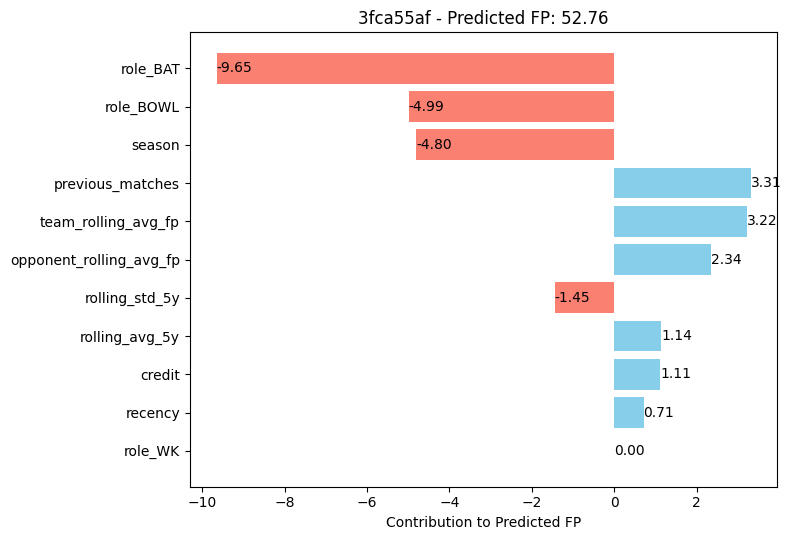

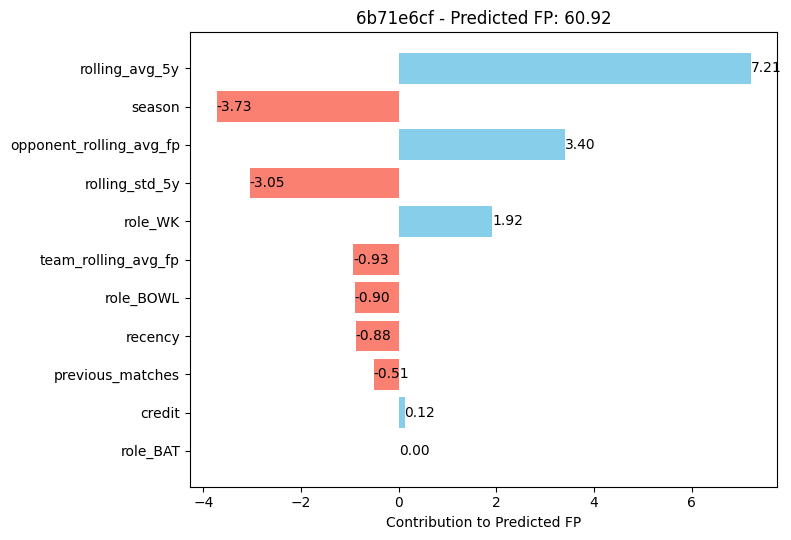

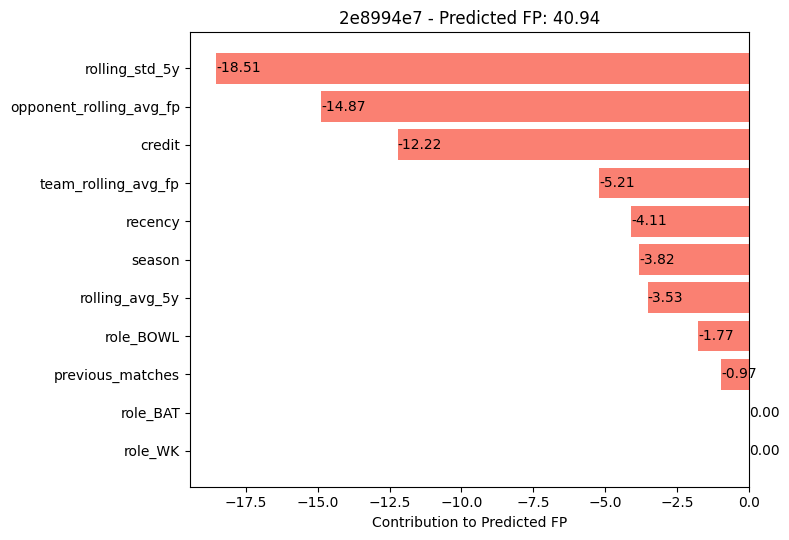

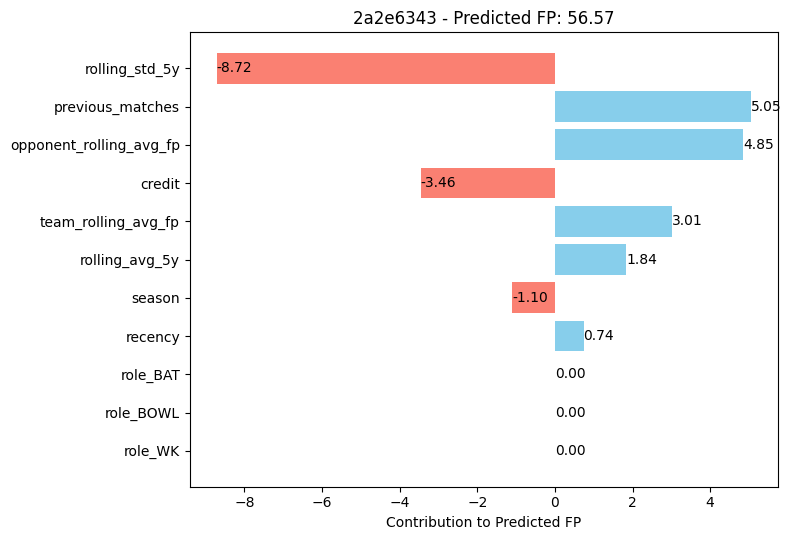

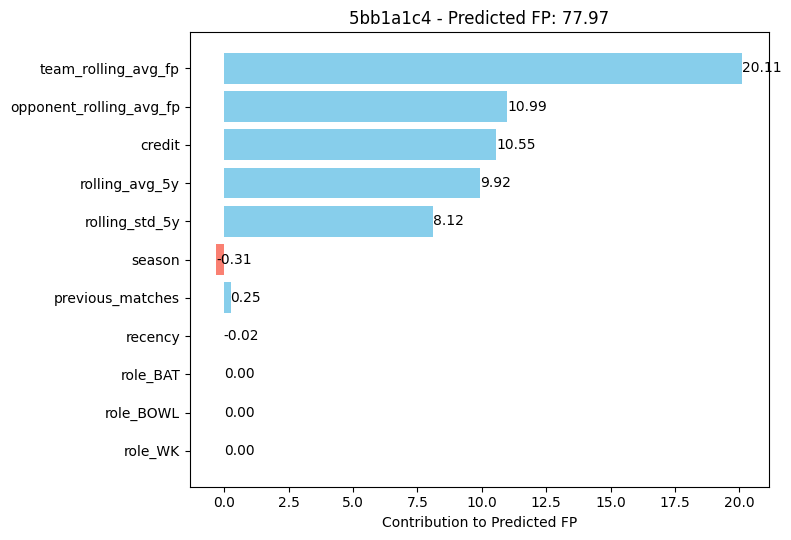

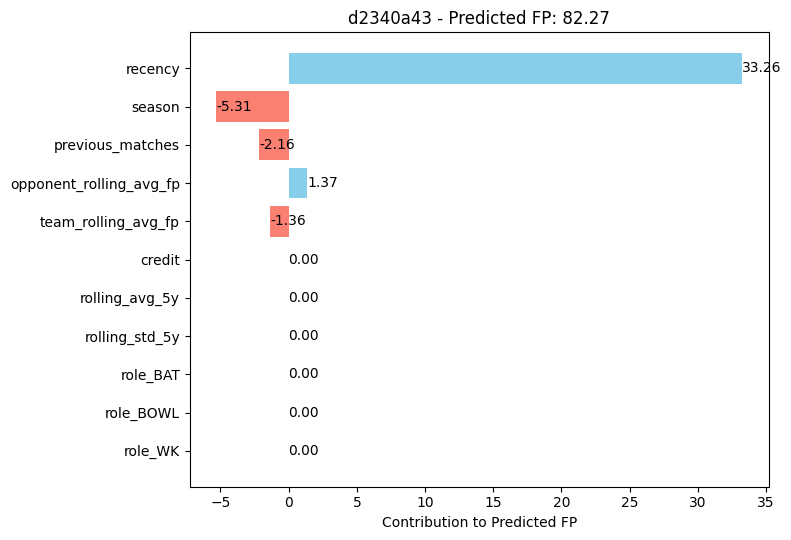

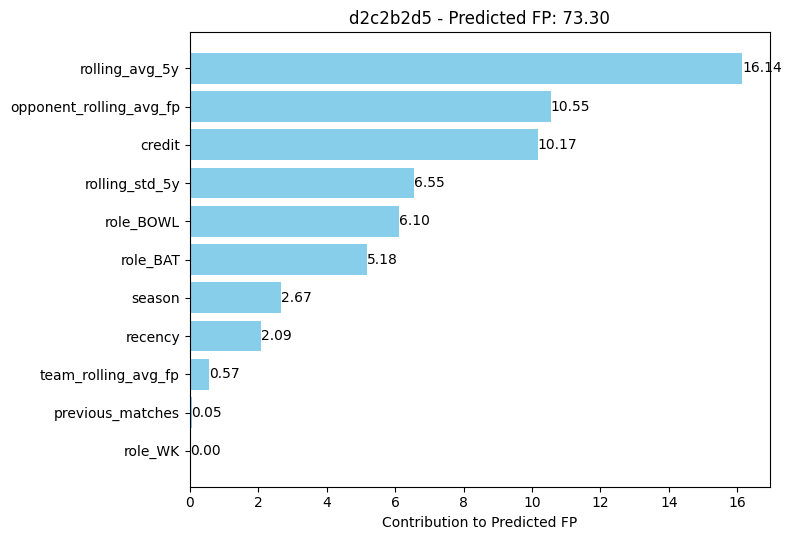

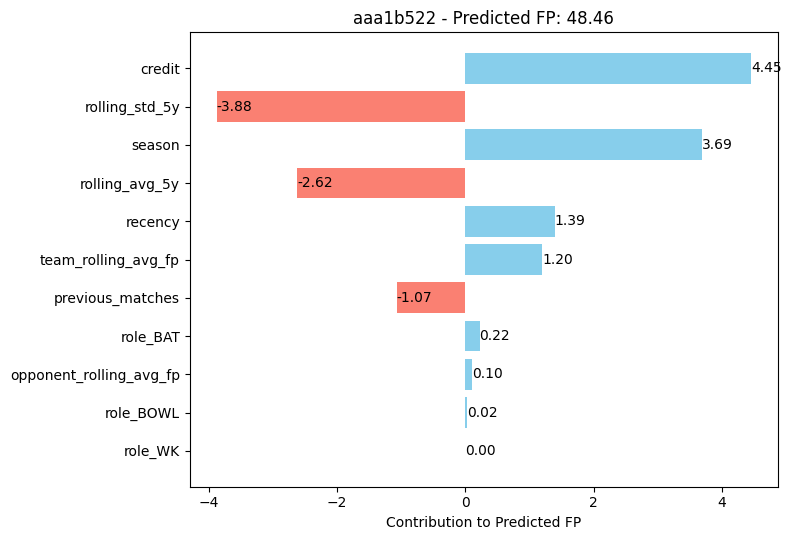

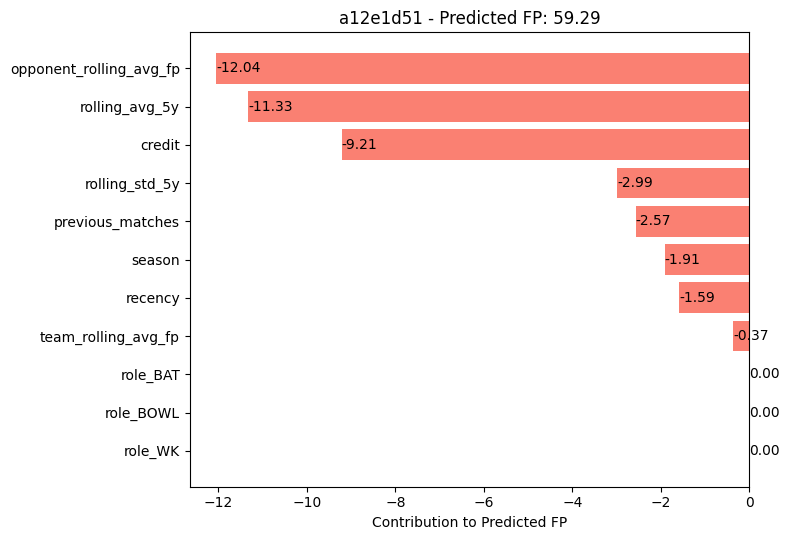

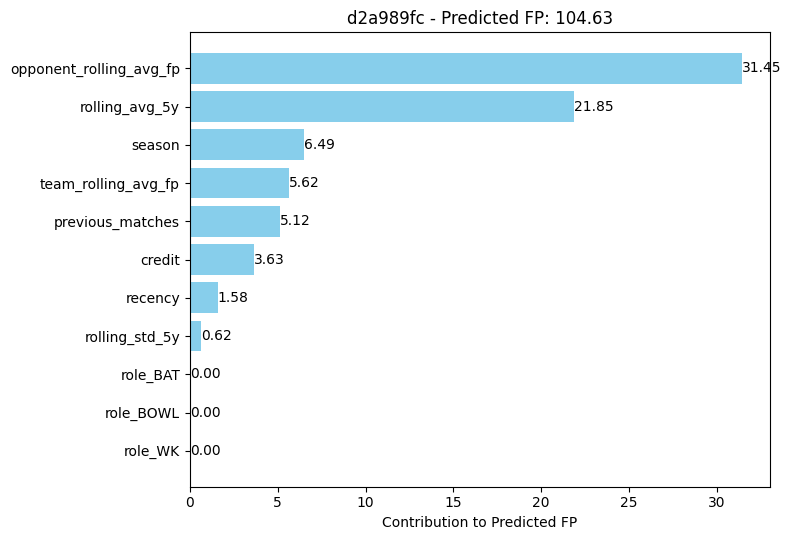

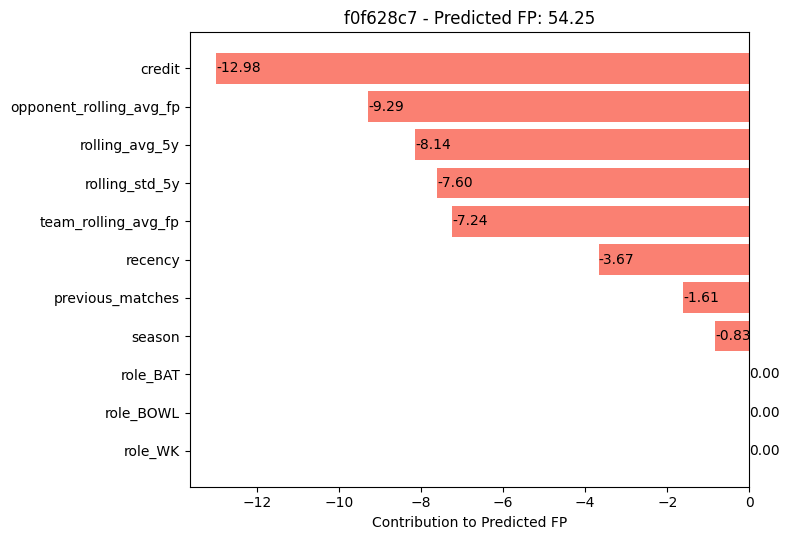


Finished generating visualizations.


In [31]:
fp_with_roles = pd.merge(
    fp,
    player_roles_season_df,
    on=["player_id", "season"],
    how="left",
    suffixes=('', '_seasonal')
)

fp_with_roles = pd.merge(
    fp_with_roles,
    player_roles_global_df,
    on="player_id",
    how="left",
    suffixes=('', '_global')
)

fp_with_roles['role'] = fp_with_roles['role_seasonal'].fillna(fp_with_roles['role_global']).fillna('BAT')

fp_with_roles.loc[
    (fp_with_roles['role'] == 'BAT') & (fp_with_roles['player_id'].isin(stumping_fielder_ids)),
    'role'
] = 'WK'


fp_with_roles = fp_with_roles.drop(columns=['role_seasonal', 'role_global'], errors='ignore')


display(fp_with_roles.head())
display(fp_with_roles['role'].value_counts())

In [32]:
# --- Calculate Actual Fantasy Points for ALL Players in the Real Match ---

if 'df' not in locals() or df.empty:
    print("Error: `df` DataFrame (containing real match data) not found or is empty.")
else:
    print("Calculating actual fantasy points for all players in the real match...")

    real_match_id = '501256'
    print(f"Using explicit real match ID: {real_match_id}")

    if real_match_id:
        if 'match_id' in df.columns:
            df_real_match_all_players = df[(df['match_id'] == real_match_id)].copy()

            print(f"Number of rows in df_real_match_all_players after filtering by match_id: {len(df_real_match_all_players)}")
            if len(df_real_match_all_players) > 0:
                print("Sample rows from df_real_match_all_players:")
                display(df_real_match_all_players.head())

                player_deliveries_all = []

                batter_deliveries = df_real_match_all_players.copy()
                batter_deliveries['player_id'] = batter_deliveries['batter_id']
                player_deliveries_all.append(batter_deliveries)

                bowler_deliveries = df_real_match_all_players.copy()
                bowler_deliveries['player_id'] = bowler_deliveries['bowler_id']
                player_deliveries_all.append(bowler_deliveries)

                df_player_deliveries_all = pd.concat(player_deliveries_all, ignore_index=True)
                df_player_deliveries_all = df_player_deliveries_all[['player_id', 'runs_batter', 'runs_extras', 'wickets']].copy()

                if 'compute_fantasy_points' in locals():
                    actual_fp_all_players = df_player_deliveries_all.groupby('player_id').apply(compute_fantasy_points).reset_index(name='actual_fantasy_points')

                    print("\nActual Fantasy Points for all players in the real match:")
                    display(actual_fp_all_players.head())

                    if 'df_squad_real' in locals() and not df_squad_real.empty:
                        df_squad_actual_fp_base = df_squad_real[['player_id', 'team', 'match_date', 'season']].copy()

                        df_squad_actual_fp = pd.merge(
                            df_squad_actual_fp_base,
                            actual_fp_all_players,
                            on='player_id',
                            how='left'
                        )

                        if 'df_squad' in locals() and not df_squad.empty:
                             df_squad_roles_credits = df_squad[['player_id', 'role', 'credit']].copy()
                             df_squad_roles_credits = df_squad_roles_credits.drop_duplicates(subset=['player_id']).reset_index(drop=True)

                             df_squad_actual_fp = pd.merge(
                                 df_squad_actual_fp,
                                 df_squad_roles_credits,
                                 on='player_id',
                                 how='left'
                             )

                             df_squad_actual_fp['role'] = df_squad_actual_fp['role'].fillna('BAT')
                             if 'feature_medians' in locals() and feature_medians is not None and 'credit' in feature_medians:
                                df_squad_actual_fp['credit'] = df_squad_actual_fp['credit'].fillna(feature_medians['credit'])
                             else:
                                df_squad_actual_fp['credit'] = df_squad_actual_fp['credit'].fillna(7.75)


                        else:
                             print("Warning: df_squad not found. Using roles and credits from df_squad_real, which might be incomplete.")
                             df_squad_actual_fp['role'] = df_squad_actual_fp['role'].fillna('BAT')
                             if 'feature_medians' in locals() and feature_medians is not None and 'credit' in feature_medians:
                                df_squad_actual_fp['credit'] = df_squad_actual_fp['credit'].fillna(feature_medians['credit'])
                             else:
                                df_squad_actual_fp['credit'] = df_squad_actual_fp['credit'].fillna(7.75)


                        df_squad_actual_fp['actual_fantasy_points'] = df_squad_actual_fp['actual_fantasy_points'].fillna(0)


                        print("\nSquad DataFrame with Actual Fantasy Points for ILP:")
                        display(df_squad_actual_fp.head())
                        display(df_squad_actual_fp.info())


                        prob_actual = pulp.LpProblem("Actual Fantasy Team Selection", pulp.LpMaximize)
                        print("\n--- Initialized ILP problem for Actual FP.")

                        player_vars_actual = pulp.LpVariable.dicts("SelectActual", df_squad_actual_fp['player_id'], 0, 1, pulp.LpInteger)
                        print("--- Defined binary decision variables for each player (Actual FP).")

                        df_squad_actual_fp['actual_fantasy_points'] = pd.to_numeric(df_squad_actual_fp['actual_fantasy_points'], errors='coerce').fillna(0)
                        prob_actual += pulp.lpSum([df_squad_actual_fp.loc[df_squad_actual_fp['player_id'] == player_id, 'actual_fantasy_points'].iloc[0] * player_vars_actual[player_id] for player_id in df_squad_actual_fp['player_id']]), "Total Actual Fantasy Points"
                        print("--- Set the objective to maximize total actual fantasy points.")


                        prob_actual += pulp.lpSum([player_vars_actual[player_id] for player_id in df_squad_actual_fp['player_id']]) == 11, "Total Players = 11 (Actual)"
                        print("--- Added constraint: Total Players = 11 (Actual FP).")

                        role_player_ids_actual = df_squad_actual_fp.groupby('role')['player_id'].apply(list).to_dict()

                        wk_players_actual = role_player_ids_actual.get('WK', [])
                        bat_players_actual = role_player_ids_actual.get('BAT', [])
                        ar_players_actual = role_player_ids_actual.get('AR', [])
                        bowl_players_actual = role_player_ids_actual.get('BOWL', [])

                        prob_actual += pulp.lpSum([player_vars_actual[player_id] for player_id in wk_players_actual]) >= 1, "Min WK = 1 (Actual)"
                        prob_actual += pulp.lpSum([player_vars_actual[player_id] for player_id in wk_players_actual]) <= 4, "Max WK = 4 (Actual)"
                        prob_actual += pulp.lpSum([player_vars_actual[player_id] for player_id in bat_players_actual]) >= 3, "Min BAT = 3 (Actual)"
                        prob_actual += pulp.lpSum([player_vars_actual[player_id] for player_id in bat_players_actual]) <= 6, "Max BAT = 6 (Actual)"
                        prob_actual += pulp.lpSum([player_vars_actual[player_id] for player_id in ar_players_actual]) >= 1, "Min AR = 1 (Actual)"
                        prob_actual += pulp.lpSum([player_vars_actual[player_id] for player_id in ar_players_actual]) <= 4, "Max AR = 4 (Actual)"
                        prob_actual += pulp.lpSum([player_vars_actual[player_id] for player_id in bowl_players_actual]) >= 3, "Min BOWL = 3 (Actual)"
                        prob_actual += pulp.lpSum([player_vars_actual[player_id] for player_id in bowl_players_actual]) <= 6, "Max BOWL = 6 (Actual)"
                        print("--- Added role bounds constraints (Actual FP).")

                        team_player_ids_actual = df_squad_actual_fp.groupby('team')['player_id'].apply(list).to_dict()
                        for team_name, player_ids in team_player_ids_actual.items():
                            prob_actual += pulp.lpSum([player_vars_actual[player_id] for player_id in player_ids]) <= 7, f"Max 7 players from {team_name} (Actual)"
                        print("--- Added team cap constraint (Actual FP).")

                        teams_in_squad_actual = list(team_player_ids_actual.keys())
                        if len(teams_in_squad_actual) == 2:
                            team1_players_actual = team_player_ids_actual[teams_in_squad_actual[0]]
                            team2_players_actual = team_player_ids_actual[teams_in_squad_actual[1]]
                            prob_actual += pulp.lpSum([player_vars_actual[player_id] for player_id in team1_players_actual]) >= 1, f"Min 1 player from {teams_in_squad_actual[0]} (Actual)"
                            prob_actual += pulp.lpSum([player_vars_actual[player_id] for player_id in team2_players_actual]) >= 1, f"Min 1 player from {teams_in_squad_actual[1]} (Actual)"
                            print(f"--- Added 'Both teams represented' constraint (Actual FP) for teams: {teams_in_squad_actual[0]}, {teams_in_squad_actual[1]}.")
                        elif len(teams_in_squad_actual) == 1:
                             print("--- 'Both teams represented' constraint skipped (Actual FP) as squad contains only one team.")
                        else:
                             print("--- Warning: Unexpected number of teams in the squad (Actual FP). 'Both teams represented' constraint might not apply correctly.")


                        print("\n--- Attempting to solve the ILP problem for Actual FP...")
                        try:
                            prob_actual.solve()
                            print(f"--- Solver finished with status: {pulp.LpStatus[prob_actual.status]}")

                            if prob_actual.status == pulp.LpStatusOptimal:
                                print("\n--- An optimal XI based on Actual FP has been found that satisfies all constraints!")

                                selected_xi_ids_actual = [player_id for player_id in df_squad_actual_fp['player_id'] if player_vars_actual[player_id].varValue == 1]

                                df_selected_xi_actual = df_squad_actual_fp[df_squad_actual_fp['player_id'].isin(selected_xi_ids_actual)].copy()

                                print("\n--- Optimal XI Selected (based on Actual FP and constraints): ---")
                                display(df_selected_xi_actual)

                                print("\n--- Actual Optimal XI Summary ---")
                                print("Total Actual Fantasy Points (Maximized):", pulp.value(prob_actual.objective))
                                print("Number of Players Selected:", len(df_selected_xi_actual))
                                print("Selected XI Role Counts:\n", df_selected_xi_actual['role'].value_counts())
                                print("Selected XI Team Counts:\n", df_selected_xi_actual['team'].value_counts())
                                print("Selected XI Total Credits:", df_selected_xi_actual['credit'].sum())


                            elif prob_actual.status == pulp.LpStatusInfeasible:
                                print("\n--- No feasible XI based on Actual FP exists under the given constraints.")
                                print("Review the squad data or the constraints.")

                            else:
                                print("\n--- Solver did not find an optimal solution for Actual FP or encountered another issue.")
                                print(f"Solver Status: {pulp.LpStatus[prob_actual.status]}")

                        except Exception as e:
                            print(f"\n--- Error occurred while solving the ILP problem for Actual FP: {e}")
                            print("Please check the code and your data.")

                    else:
                        print("Error: `compute_fantasy_points` function not found.")
                        print("Please ensure the cell defining this function was executed.")


            else:
                print("Error: No data found in 'df' for match_id '{real_match_id}'. Cannot calculate actual fantasy points.")

        else:
            print(f"Error: 'match_id' column not found in the 'df' DataFrame. Cannot filter real match data.")

    else:
        print("Cannot calculate actual fantasy points without a valid real match ID.")

Calculating actual fantasy points for all players in the real match...
Using explicit real match ID: 501256
Number of rows in df_real_match_all_players after filtering by match_id: 249
Sample rows from df_real_match_all_players:


,match_id,date,team,batter_name,batter_id,bowler_name,bowler_id,runs_batter,runs_extras,total_runs,wickets
105722,501256,2011-05-14,Deccan Chargers,MJ Lumb,11df3dc8,SL Malinga,a12e1d51,0,0,0,[]
105723,501256,2011-05-14,Deccan Chargers,MJ Lumb,11df3dc8,SL Malinga,a12e1d51,0,0,0,"[{'kind': 'bowled', 'player_out': 'MJ Lumb'}]"
105724,501256,2011-05-14,Deccan Chargers,KC Sangakkara,6b71e6cf,SL Malinga,a12e1d51,0,0,0,[]
105725,501256,2011-05-14,Deccan Chargers,KC Sangakkara,6b71e6cf,SL Malinga,a12e1d51,1,0,1,[]
105726,501256,2011-05-14,Deccan Chargers,S Sohal,3fca55af,SL Malinga,a12e1d51,0,0,0,[]



Actual Fantasy Points for all players in the real match:


/tmp/ipython-input-757828386.py:49: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  actual_fp_all_players = df_player_deliveries_all.groupby('player_id').apply(compute_fantasy_points).reset_index(name='actual_fantasy_points')


,player_id,actual_fantasy_points
0,0a476045,33
1,11df3dc8,35
2,1efb8a28,36
3,2a2e6343,76
4,2e8994e7,74



Squad DataFrame with Actual Fantasy Points for ILP:


,player_id,team,match_date,season,actual_fantasy_points,role,credit
0,11df3dc8,Deccan Chargers,2011-05-14,2011,35,BAT,7.84
1,3fca55af,Deccan Chargers,2011-05-14,2011,53,BAT,7.41
2,6b71e6cf,Deccan Chargers,2011-05-14,2011,59,WK,9.93
3,2e8994e7,Deccan Chargers,2011-05-14,2011,74,AR,6.37
4,5451a2c1,Deccan Chargers,2011-05-14,2011,40,BAT,4.66


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22 entries, 0 to 21
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   player_id              22 non-null     object        
 1   team                   22 non-null     object        
 2   match_date             22 non-null     datetime64[ns]
 3   season                 22 non-null     int64         
 4   actual_fantasy_points  22 non-null     int64         
 5   role                   22 non-null     object        
 6   credit                 22 non-null     float64       
dtypes: datetime64[ns](1), float64(1), int64(2), object(3)
memory usage: 1.3+ KB


None


--- Initialized ILP problem for Actual FP.
--- Defined binary decision variables for each player (Actual FP).
--- Set the objective to maximize total actual fantasy points.
--- Added constraint: Total Players = 11 (Actual FP).
--- Added role bounds constraints (Actual FP).
--- Added team cap constraint (Actual FP).
--- Added 'Both teams represented' constraint (Actual FP) for teams: Deccan Chargers, Mumbai Indians.

--- Attempting to solve the ILP problem for Actual FP...
--- Solver finished with status: Optimal

--- An optimal XI based on Actual FP has been found that satisfies all constraints!

--- Optimal XI Selected (based on Actual FP and constraints): ---


/usr/local/lib/python3.12/dist-packages/pulp/pulp.py:1489: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")


,player_id,team,match_date,season,actual_fantasy_points,role,credit
1,3fca55af,Deccan Chargers,2011-05-14,2011,53,BAT,7.41
2,6b71e6cf,Deccan Chargers,2011-05-14,2011,59,WK,9.93
3,2e8994e7,Deccan Chargers,2011-05-14,2011,74,AR,6.37
5,2a2e6343,Deccan Chargers,2011-05-14,2011,76,BOWL,5.52
9,5bb1a1c4,Deccan Chargers,2011-05-14,2011,94,BOWL,7.13
10,d2340a43,Deccan Chargers,2011-05-14,2011,130,BOWL,7.75
11,d2c2b2d5,Mumbai Indians,2011-05-14,2011,77,BAT,9.37
16,aaa1b522,Mumbai Indians,2011-05-14,2011,62,BAT,6.17
17,a757b0d8,Mumbai Indians,2011-05-14,2011,90,BOWL,7.05
18,8b5b6769,Mumbai Indians,2011-05-14,2011,89,BOWL,6.45



--- Actual Optimal XI Summary ---
Total Actual Fantasy Points (Maximized): 919.0
Number of Players Selected: 11
Selected XI Role Counts:
 role
BOWL    6
BAT     3
WK      1
AR      1
Name: count, dtype: int64
Selected XI Team Counts:
 team
Deccan Chargers    6
Mumbai Indians     5
Name: count, dtype: int64
Selected XI Total Credits: 80.94000000000001


In [33]:
# --- Calculate Actual Fantasy Points for the Selected XI ---

if 'df_selected_xi' not in locals() or df_selected_xi.empty:
    print("Error: `df_selected_xi` DataFrame not found or is empty.")
elif 'df' not in locals() or df.empty:
    print("Error: `df` DataFrame (containing real match data) not found or is empty.")
else:
    print("Calculating actual fantasy points for the selected optimal XI...")

    real_match_id = '501256'
    print(f"Using explicit real match ID: {real_match_id}")


    if real_match_id:
        if 'match_id' in df.columns:
            df_real_match = df[(df['match_id'] == real_match_id)].copy()

            print(f"Number of rows in df_real_match after filtering by match_id: {len(df_real_match)}")
            if len(df_real_match) > 0:
                print("Sample rows from df_real_match:")
                display(df_real_match.head())
            else:
                print(f"Warning: No data found in 'df' for match_id '{real_match_id}'. Please check the match ID and the 'df' DataFrame.")


            selected_player_ids = df_selected_xi['player_id'].tolist()
            print(f"Selected XI Player IDs ({len(selected_player_ids)}): {selected_player_ids}")

            df_real_match_xi = df_real_match[
                (df_real_match['batter_id'].isin(selected_player_ids)) |
                (df_real_match['bowler_id'].isin(selected_player_ids))
            ].copy()


            print(f"Number of rows in df_real_match_xi after filtering by player IDs: {len(df_real_match_xi)}")
            if len(df_real_match_xi) > 0:
                print("Sample rows from df_real_match_xi:")
                display(df_real_match_xi.head())
            else:
                print("Error: No deliveries found in the real match data for the selected XI players.")
                print("This could mean the player IDs in df_selected_xi do not match 'batter_id' or 'bowler_id' in df for this match.")
                print("Double-checking player IDs in both dataframes:")
                print("Player IDs in df_selected_xi:", df_selected_xi['player_id'].tolist())
                if not df_real_match.empty:
                    print("Batter IDs in df_real_match:", df_real_match['batter_id'].unique().tolist())
                    print("Bowler IDs in df_real_match:", df_real_match['bowler_id'].unique().tolist())
                else:
                    print("df_real_match is empty, cannot check batter/bowler IDs.")



            if 'compute_fantasy_points' in locals():
                if len(df_real_match_xi) > 0:
                    player_deliveries = []
                    for player_id in selected_player_ids:
                        deliveries = df_real_match_xi[(df_real_match_xi['batter_id'] == player_id) | (df_real_match_xi['bowler_id'] == player_id)].copy()
                        if not deliveries.empty:
                             deliveries['player_id'] = player_id
                             player_deliveries.append(deliveries)

                    if player_deliveries:
                         df_player_deliveries = pd.concat(player_deliveries, ignore_index=True)

                         actual_fp_xi = df_player_deliveries.groupby('player_id')[['runs_batter', 'runs_extras', 'wickets']].apply(compute_fantasy_points).reset_index(name='actual_fantasy_points')


                         df_selected_xi_actual_fp = pd.merge(
                             df_selected_xi[['player_id', 'team', 'role', 'credit', 'predicted_fantasy_points']],
                             actual_fp_xi[['player_id', 'actual_fantasy_points']],
                             on='player_id',
                             how='left'
                         )

                         df_selected_xi_actual_fp['actual_fantasy_points'] = df_selected_xi_actual_fp['actual_fantasy_points'].fillna(0)


                         print("\nOptimal XI with Actual Fantasy Points:")
                         display(df_selected_xi_actual_fp)

                         print("\n--- Actual Selected XI Summary ---")
                         print("Total Actual Fantasy Points:", df_selected_xi_actual_fp['actual_fantasy_points'].sum())
                         print("Number of Players Selected:", len(df_selected_xi_actual_fp))
                         print("Selected XI Role Counts:\n", df_selected_xi_actual_fp['role'].value_counts())
                         print("Selected XI Team Counts:\n", df_selected_xi_actual_fp['team'].value_counts())
                         print("Selected XI Total Credits:", df_selected_xi_actual_fp['credit'].sum())


                    else:
                         print("No deliveries found for selected players in the real match after creating player_deliveries list.")
                         df_selected_xi_actual_fp = df_selected_xi[['player_id', 'team', 'role', 'credit', 'predicted_fantasy_points']].copy()
                         df_selected_xi_actual_fp['actual_fantasy_points'] = 0
                         print("\nOptimal XI with Actual Fantasy Points (all 0 as no deliveries found):")
                         display(df_selected_xi_actual_fp)


                else:
                     print("df_real_match_xi is empty, cannot calculate actual fantasy points.")
                     df_selected_xi_actual_fp = df_selected_xi[['player_id', 'team', 'role', 'credit', 'predicted_fantasy_points']].copy()
                     df_selected_xi_actual_fp['actual_fantasy_points'] = 0
                     print("\nOptimal XI with Actual Fantasy Points (all 0 as df_real_match_xi is empty):")
                     display(df_selected_xi_actual_fp)


            else:
                print("Error: `compute_fantasy_points` function not found.")
                print("Please ensure the cell defining this function was executed.")

        else:
            print(f"Error: 'match_id' column not found in the 'df' DataFrame. Cannot filter real match data.")

    else:
        print("Cannot calculate actual fantasy points without a valid real match ID.")

Calculating actual fantasy points for the selected optimal XI...
Using explicit real match ID: 501256
Number of rows in df_real_match after filtering by match_id: 249
Sample rows from df_real_match:


,match_id,date,team,batter_name,batter_id,bowler_name,bowler_id,runs_batter,runs_extras,total_runs,wickets
105722,501256,2011-05-14,Deccan Chargers,MJ Lumb,11df3dc8,SL Malinga,a12e1d51,0,0,0,[]
105723,501256,2011-05-14,Deccan Chargers,MJ Lumb,11df3dc8,SL Malinga,a12e1d51,0,0,0,"[{'kind': 'bowled', 'player_out': 'MJ Lumb'}]"
105724,501256,2011-05-14,Deccan Chargers,KC Sangakkara,6b71e6cf,SL Malinga,a12e1d51,0,0,0,[]
105725,501256,2011-05-14,Deccan Chargers,KC Sangakkara,6b71e6cf,SL Malinga,a12e1d51,1,0,1,[]
105726,501256,2011-05-14,Deccan Chargers,S Sohal,3fca55af,SL Malinga,a12e1d51,0,0,0,[]


Selected XI Player IDs (11): ['3fca55af', '6b71e6cf', '2e8994e7', '2a2e6343', '5bb1a1c4', 'd2340a43', 'd2c2b2d5', 'aaa1b522', 'a12e1d51', 'd2a989fc', 'f0f628c7']
Number of rows in df_real_match_xi after filtering by player IDs: 215
Sample rows from df_real_match_xi:


,match_id,date,team,batter_name,batter_id,bowler_name,bowler_id,runs_batter,runs_extras,total_runs,wickets
105722,501256,2011-05-14,Deccan Chargers,MJ Lumb,11df3dc8,SL Malinga,a12e1d51,0,0,0,[]
105723,501256,2011-05-14,Deccan Chargers,MJ Lumb,11df3dc8,SL Malinga,a12e1d51,0,0,0,"[{'kind': 'bowled', 'player_out': 'MJ Lumb'}]"
105724,501256,2011-05-14,Deccan Chargers,KC Sangakkara,6b71e6cf,SL Malinga,a12e1d51,0,0,0,[]
105725,501256,2011-05-14,Deccan Chargers,KC Sangakkara,6b71e6cf,SL Malinga,a12e1d51,1,0,1,[]
105726,501256,2011-05-14,Deccan Chargers,S Sohal,3fca55af,SL Malinga,a12e1d51,0,0,0,[]



Optimal XI with Actual Fantasy Points:


/tmp/ipython-input-2870092043.py:82: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  actual_fp_xi = df_player_deliveries.groupby('player_id').apply(compute_fantasy_points).reset_index(name='actual_fantasy_points')


,player_id,team,role,credit,predicted_fantasy_points,actual_fantasy_points
0,3fca55af,Deccan Chargers,BAT,7.41,52.76,53
1,6b71e6cf,Deccan Chargers,WK,9.93,60.92,59
2,2e8994e7,Deccan Chargers,AR,6.37,40.94,74
3,2a2e6343,Deccan Chargers,BOWL,5.52,56.57,76
4,5bb1a1c4,Deccan Chargers,BOWL,7.13,77.97,94
5,d2340a43,Deccan Chargers,BOWL,7.75,82.27,130
6,d2c2b2d5,Mumbai Indians,BAT,9.37,73.30,77
7,aaa1b522,Mumbai Indians,BAT,6.17,48.46,62
8,a12e1d51,Mumbai Indians,BOWL,10.96,59.29,57
9,d2a989fc,Mumbai Indians,BOWL,7.79,104.63,115



--- Actual Selected XI Summary ---
Total Actual Fantasy Points: 844
Number of Players Selected: 11
Selected XI Role Counts:
 role
BOWL    6
BAT     3
WK      1
AR      1
Name: count, dtype: int64
Selected XI Team Counts:
 team
Deccan Chargers    6
Mumbai Indians     5
Name: count, dtype: int64
Selected XI Total Credits: 89.19
